In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, GRU
from keras.initializers import HeNormal
from keras_self_attention import SeqSelfAttention
import MetaTrader5 as mt5
from datetime import datetime
import tf2onnx
import os

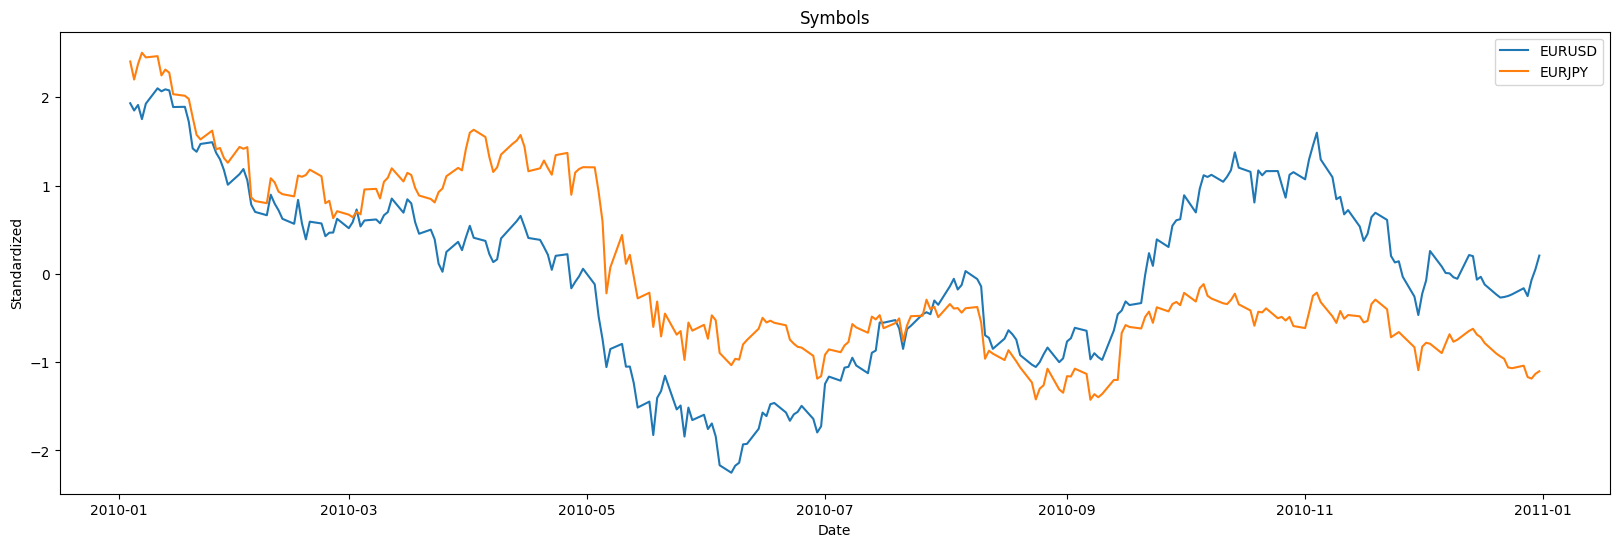

In [2]:
mt5.initialize()
inp_start_date = datetime(2010, 1, 1) # Start Date
inp_end_date = datetime(2010, 12, 31) # End Date

symbols = ["EURUSD", "EURJPY"] # Custom Symbol
""" 
symbols = ["AUDCAD", "AUDCHF", "AUDJPY", "AUDNZD", "AUDUSD", "CADCHF", "CADJPY", "CHFJPY",
           "EURAUD", "EURCAD", "EURCHF", "EURGBP", "EURJPY", "EURNZD", "EURUSD", "GBPAUD",
           "GBPCAD", "GBPCHF", "GBPJPY", "GBPNZD", "GBPUSD", "NZDCAD", "NZDCHF", "NZDJPY",
           "NZDUSD", "USDCAD", "USDCHF", "USDJPY", "USDSGD"] # All Symbols
"""


# Get data from the client terminal
symbols_data = {}
for symbol in symbols:
    symbol_rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, inp_start_date, inp_end_date)
    symbols_data[symbol] = {"data": pd.DataFrame(symbol_rates)}

# Concatenate data for all symbols
df = pd.concat([symbols_data[symbol]["data"] for symbol in symbols], keys=symbols)
df = df.rename(columns={'time': 'date'})
df = df.rename(columns={'tick_volume': 'volume'})
df = df.drop(columns=['spread', 'real_volume'])
df['date'] = pd.to_datetime(df['date'], unit='s')

# Convert numeric columns to float64 data type
numeric_columns = ['open', 'high', 'low', 'close', 'volume']
df[numeric_columns] = df[numeric_columns].astype('float64')

# Standardize all columns for each symbol
scaler = StandardScaler()
for symbol in symbols:
    df.loc[symbol, numeric_columns] = scaler.fit_transform(df.loc[symbol, numeric_columns])

# Plot standardized data
plt.figure(figsize=(20, 6))
for symbol in symbols:
    plt.plot(df.loc[symbol]['date'], df.loc[symbol]['close'], label=symbol) 

plt.xlabel('Date')
plt.ylabel('Standardized')
plt.legend()
plt.title('Symbols')
plt.show() 

In [3]:
df.head()

date      open      high       low     close    volume
EURUSD 0 2010-01-04  1.768498  1.882368  1.786122  1.931311 -0.332383
       1 2010-01-05  1.909845  1.930777  1.936248  1.849627 -0.265146
       2 2010-01-06  1.830670  1.847790  1.829922  1.912358 -0.336368
       3 2010-01-07  1.892176  1.867693  1.857172  1.751842 -0.401099
       4 2010-01-08  1.731828  1.835139  1.796988  1.926950 -0.963185

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 520 entries, ('EURUSD', 0) to ('EURJPY', 259)
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    520 non-null    datetime64[ns]
 1   open    520 non-null    float64       
 2   high    520 non-null    float64       
 3   low     520 non-null    float64       
 4   close   520 non-null    float64       
 5   volume  520 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 26.2+ KB


In [5]:
df.describe()

,date,open,high,low,close,volume
count,520,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02,5.200000e+02
mean,2010-07-03 12:00:00,7.310392e-16,-1.296399e-15,6.456374e-16,-1.078624e-15,1.503071e-16
min,2010-01-04 00:00:00,-2.247548e+00,-2.273068e+00,-2.194558e+00,-2.252678e+00,-2.133601e+00
25%,2010-04-04 06:00:00,-7.403559e-01,-7.450509e-01,-7.564916e-01,-7.448985e-01,-6.428877e-01
50%,2010-07-03 12:00:00,-2.409687e-01,-2.466038e-01,-2.231261e-01,-2.337291e-01,-2.630115e-01
75%,2010-10-01 18:00:00,8.251171e-01,8.124378e-01,8.045348e-01,8.295085e-01,4.634501e-01
max,2010-12-31 00:00:00,2.461477e+00,2.433024e+00,2.551682e+00,2.503819e+00,5.568066e+00
std,NaN,1.000963e+00,1.000963e+00,1.000963e+00,1.000963e+00,1.000963e+00


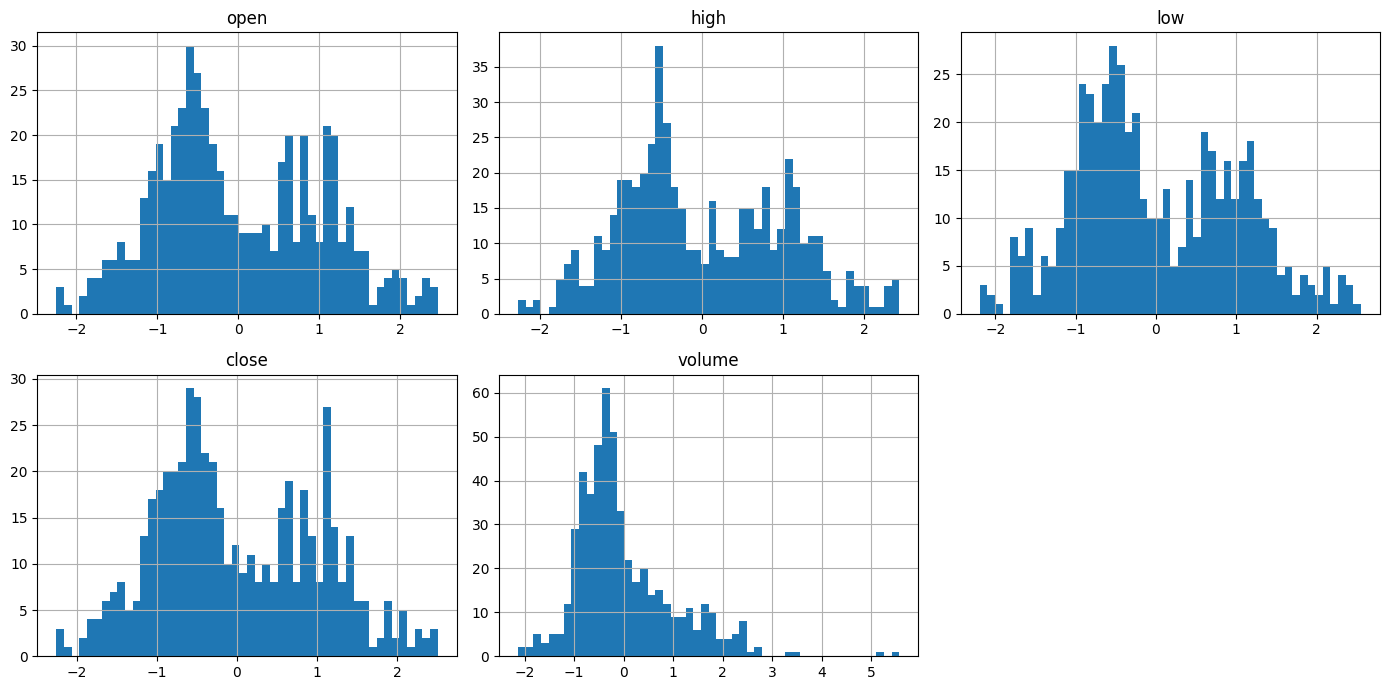

In [6]:
df_plot = df[df['date'] >= '2000-01-01']

# Create a figure and subgraphs
plt.figure(figsize=(14, 7))

# Iterate over the columns and create the subgraphs
for i, column in enumerate(['open', 'high', 'low', 'close', 'volume']):
    plt.subplot(2, 3, i+1)
    df_plot[column].hist(bins=50)
    plt.title(column)

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

# Data Analysis

In [7]:
# Converting the 'Date' column to datetime format and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [8]:
df.mean()

open      7.310392e-16
high     -1.296399e-15
low       6.456374e-16
close    -1.078624e-15
volume    1.503071e-16
dtype: float64

In [9]:
df.median()

open     -0.240969
high     -0.246604
low      -0.223126
close    -0.233729
volume   -0.263012
dtype: float64

In [10]:
df.skew()

open      0.275577
high      0.278621
low       0.283377
close     0.277108
volume    1.331555
dtype: float64

In [11]:
df.shape

(520, 5)

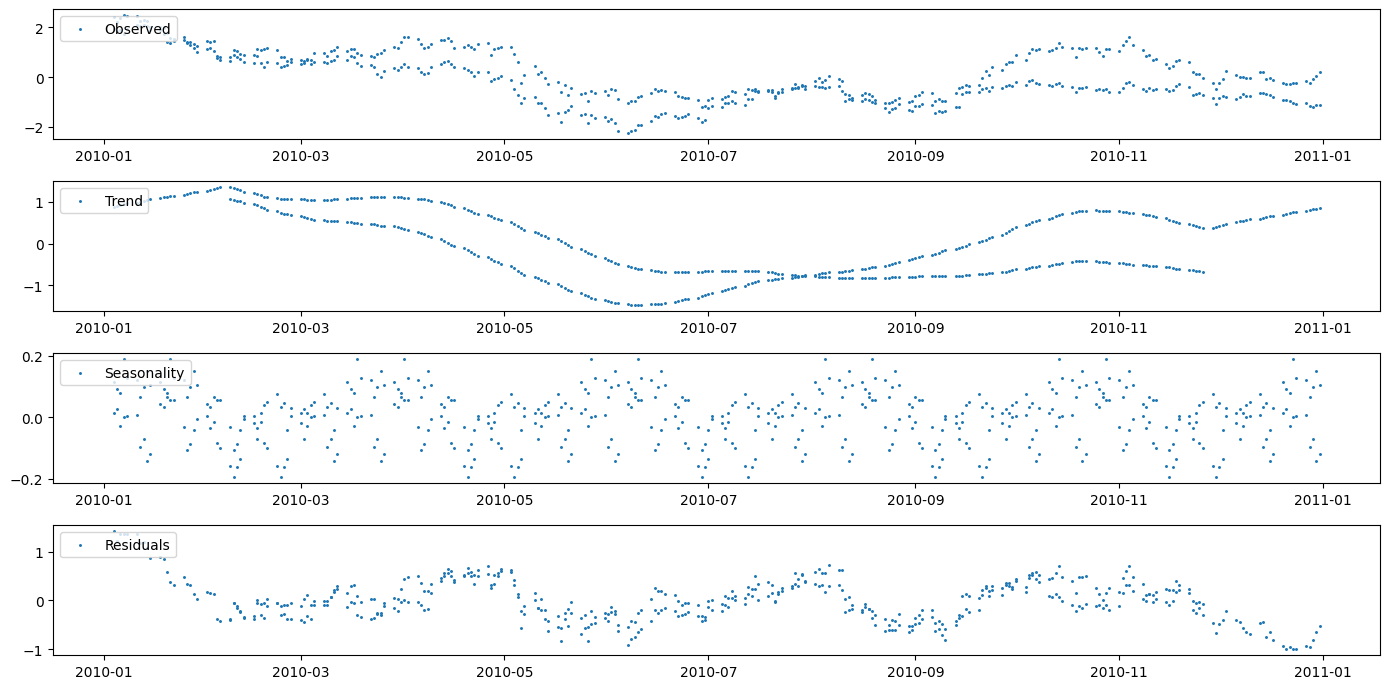

In [12]:
decomposition = seasonal_decompose(df['close'], model='additive', period=50)  # Assuming number of trading days in a year
plt.figure(figsize=(14, 7))

# Observed
plt.subplot(411)
plt.scatter(decomposition.observed.index, decomposition.observed, label='Observed', marker='.', s=5)
plt.legend(loc='upper left')

# Trend
plt.subplot(412)
plt.scatter(decomposition.trend.index, decomposition.trend, label='Trend', marker='.', s=5)
plt.legend(loc='upper left')

# Seasonality
plt.subplot(413)
plt.scatter(decomposition.seasonal.index, decomposition.seasonal, label='Seasonality', marker='.', s=5)
plt.legend(loc='upper left')

# Residuals
plt.subplot(414)
plt.scatter(decomposition.resid.index, decomposition.resid, label='Residuals', marker='.', s=5)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


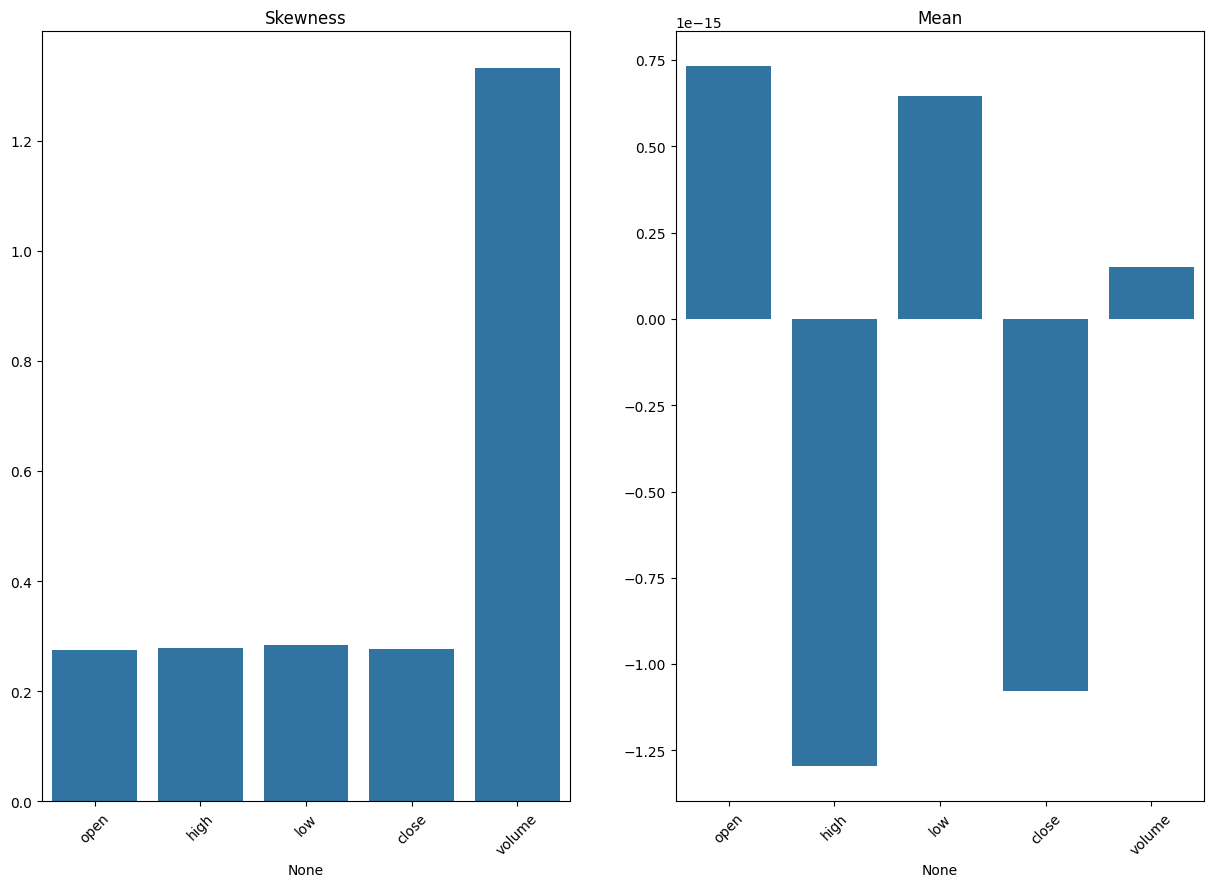

In [13]:
skewness_values = df.skew()
mean_values = df.mean()
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.barplot(x=skewness_values.index, y=skewness_values.values, ax=ax[0])
ax[0].set_title('Skewness')
ax[0].tick_params(axis='x', rotation=45)
sns.barplot(x=mean_values.index, y=mean_values.values, ax=ax[1])
ax[1].set_title('Mean')
ax[1].tick_params(axis='x', rotation=45)
plt.show()

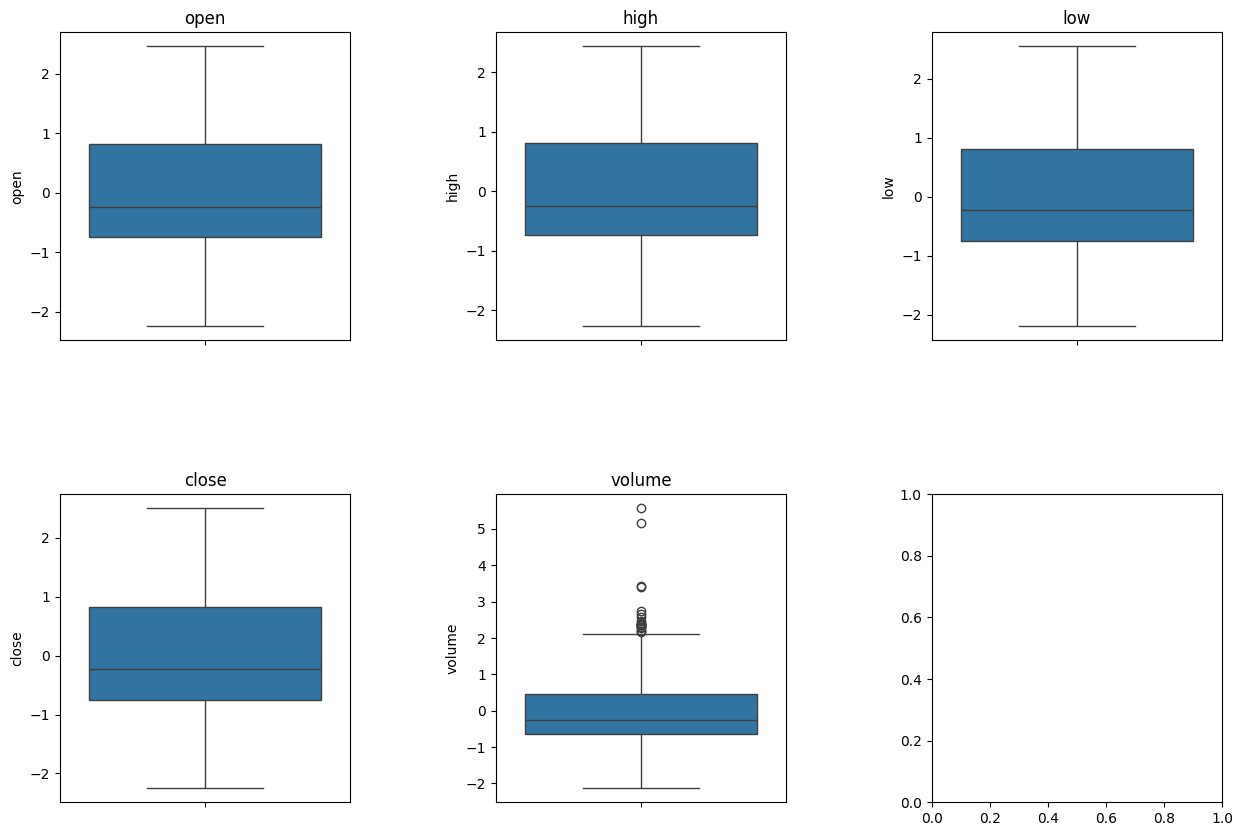

In [14]:
columns_per_row = 3
num_columns = len(df.describe().columns)
num_rows = -(-num_columns // columns_per_row)

fig, ax = plt.subplots(num_rows, columns_per_row, figsize=(15, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, column in enumerate(df.describe().columns):
    current_row = i // columns_per_row
    current_column = i % columns_per_row
    sns.boxplot(df[column], ax=ax[current_row, current_column])
    ax[current_row, current_column].set_title(column)

plt.show()

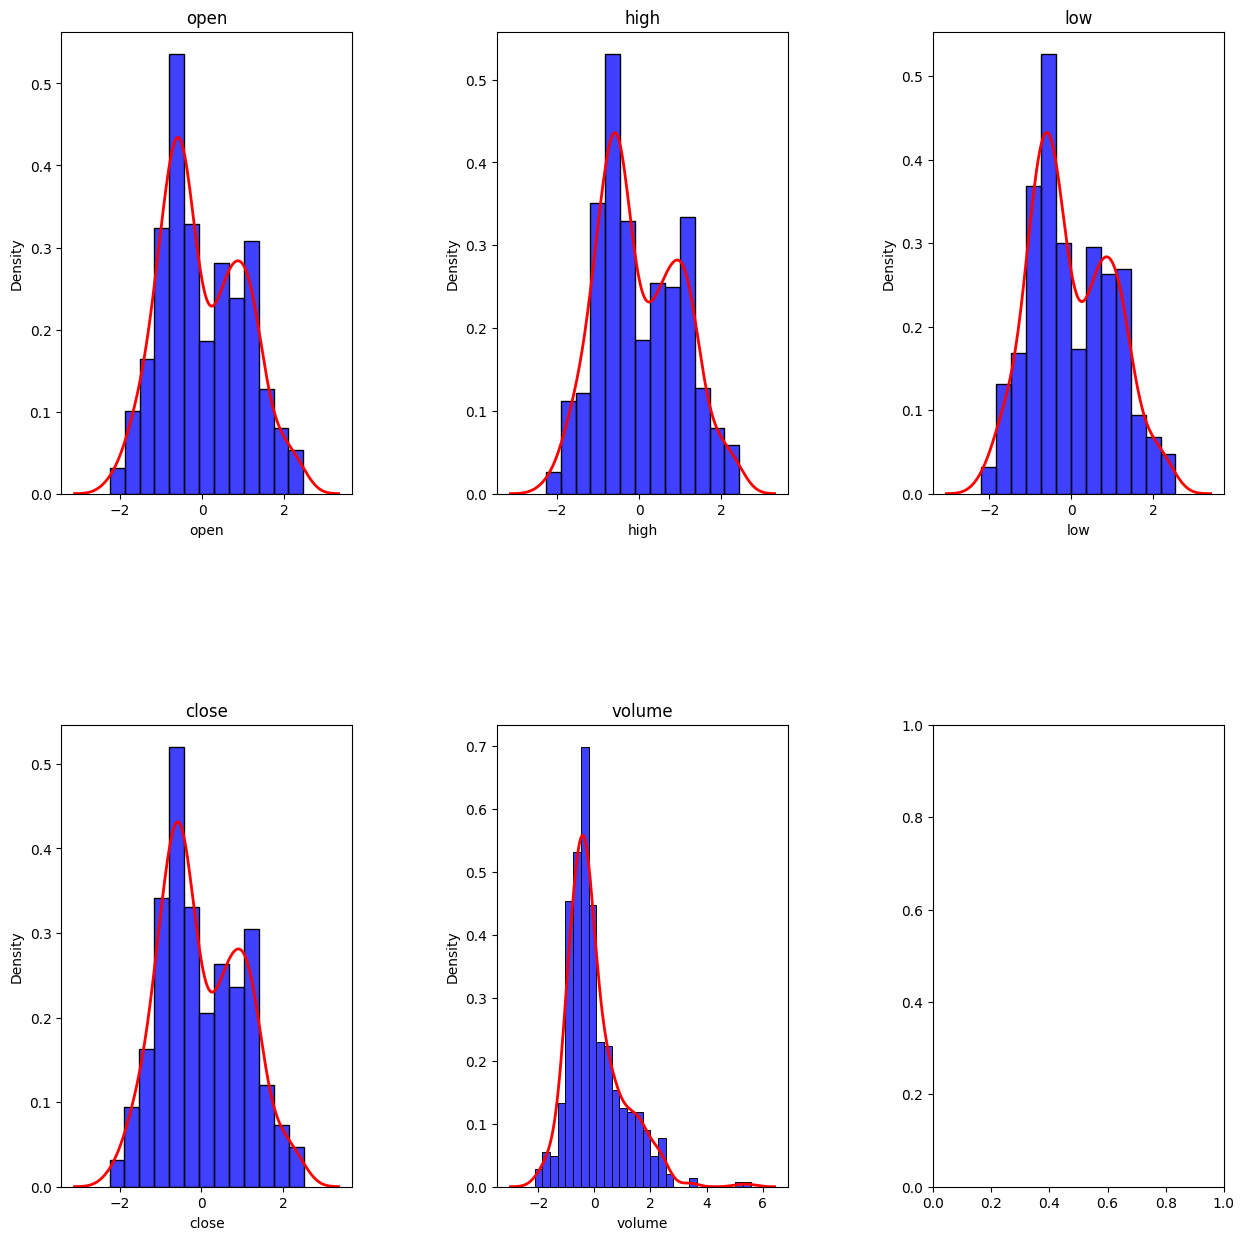

In [15]:
columns_per_row = 3
num_columns = len(df.describe().columns)
num_rows = -(-num_columns // columns_per_row)

fig, ax = plt.subplots(num_rows, columns_per_row, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, column in enumerate(df.describe().columns):
    current_row = i // columns_per_row
    current_column = i % columns_per_row
    
    sns.histplot(df[column], ax=ax[current_row, current_column], color='blue', stat="density", kde_kws={'bw_method': 0.2})
    
    sns.kdeplot(df[column], ax=ax[current_row, current_column], color='red', linewidth=2)
    
    ax[current_row, current_column].set_title(column)

plt.show()

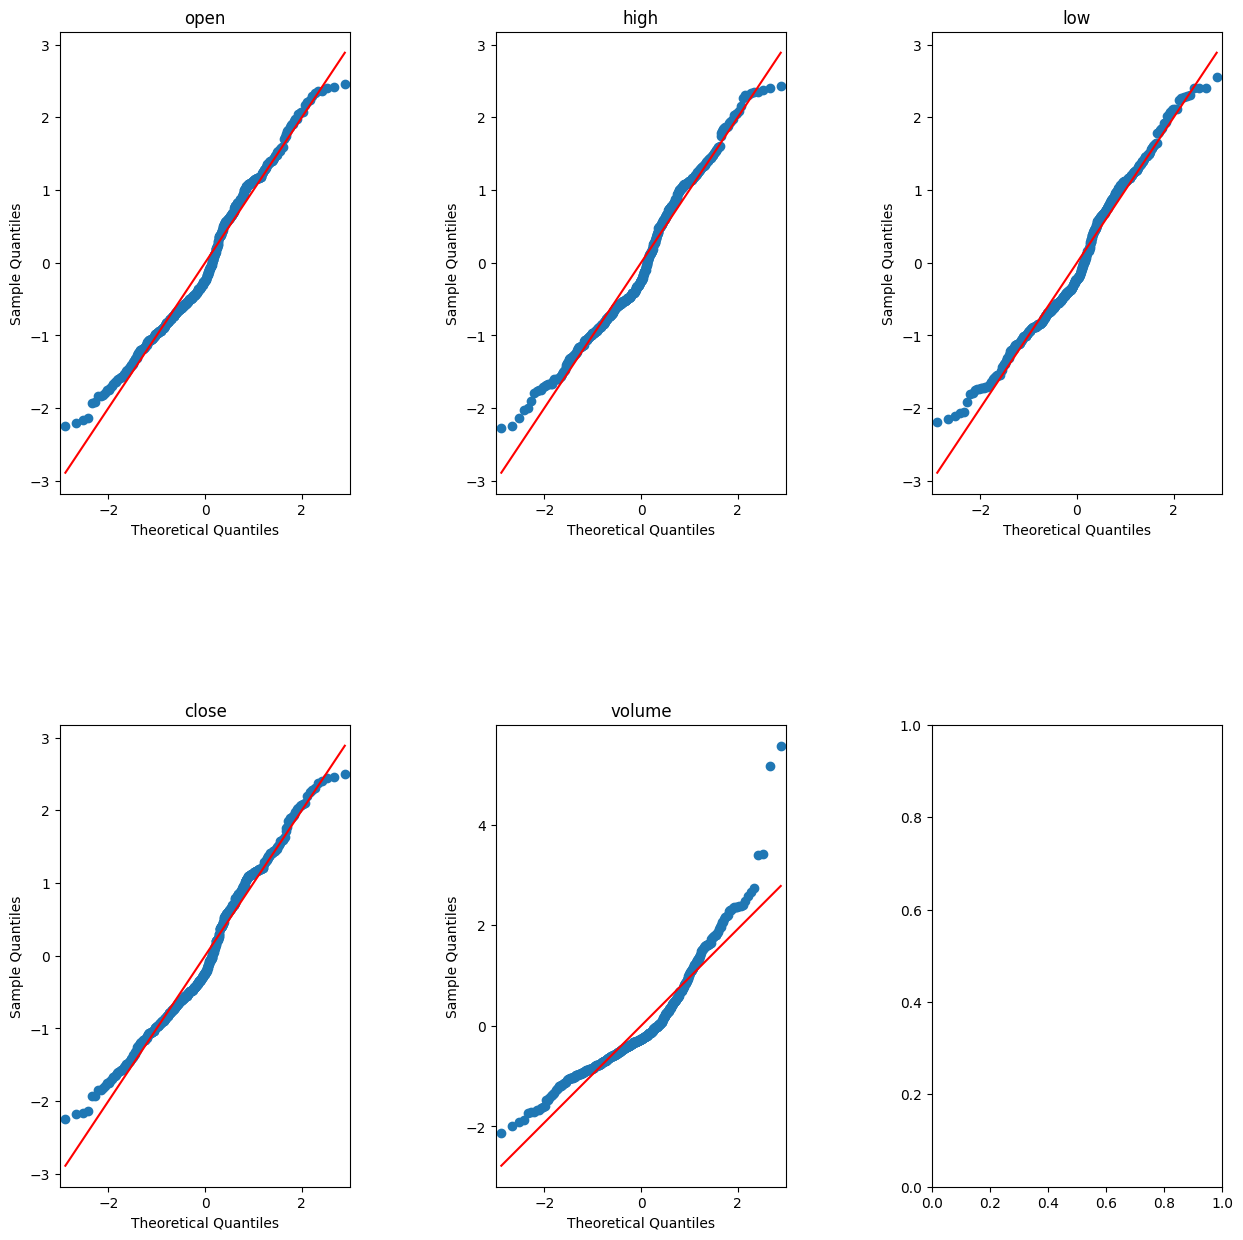

In [16]:
columns_per_row = 3
num_columns = len(df.describe().columns)
num_rows = -(-num_columns // columns_per_row)

fig, ax = plt.subplots(num_rows, columns_per_row, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, column in enumerate(df.describe().columns):
    current_row = i // columns_per_row
    current_column = i % columns_per_row
    
    smi.qqplot(df[column], ax=ax[current_row, current_column], line="r")
    ax[current_row, current_column].set_title(column)

plt.show()

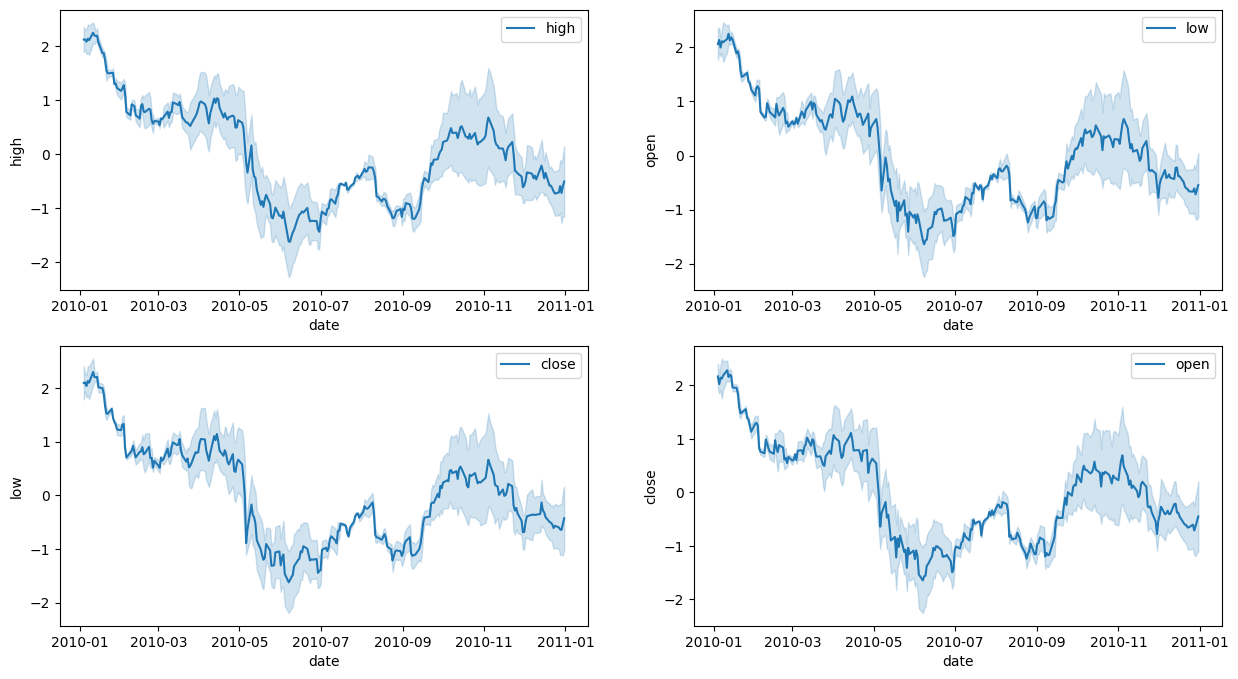

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.lineplot(data=df, x='date', y='high', label='high', ax = ax[0,0])
sns.lineplot(data=df, x='date', y='open', label='low',ax = ax[0,1])
sns.lineplot(data=df, x='date', y='low', label='close',ax = ax[1,0])
sns.lineplot(data=df, x='date', y='close', label='open',ax = ax[1,1])
plt.show()

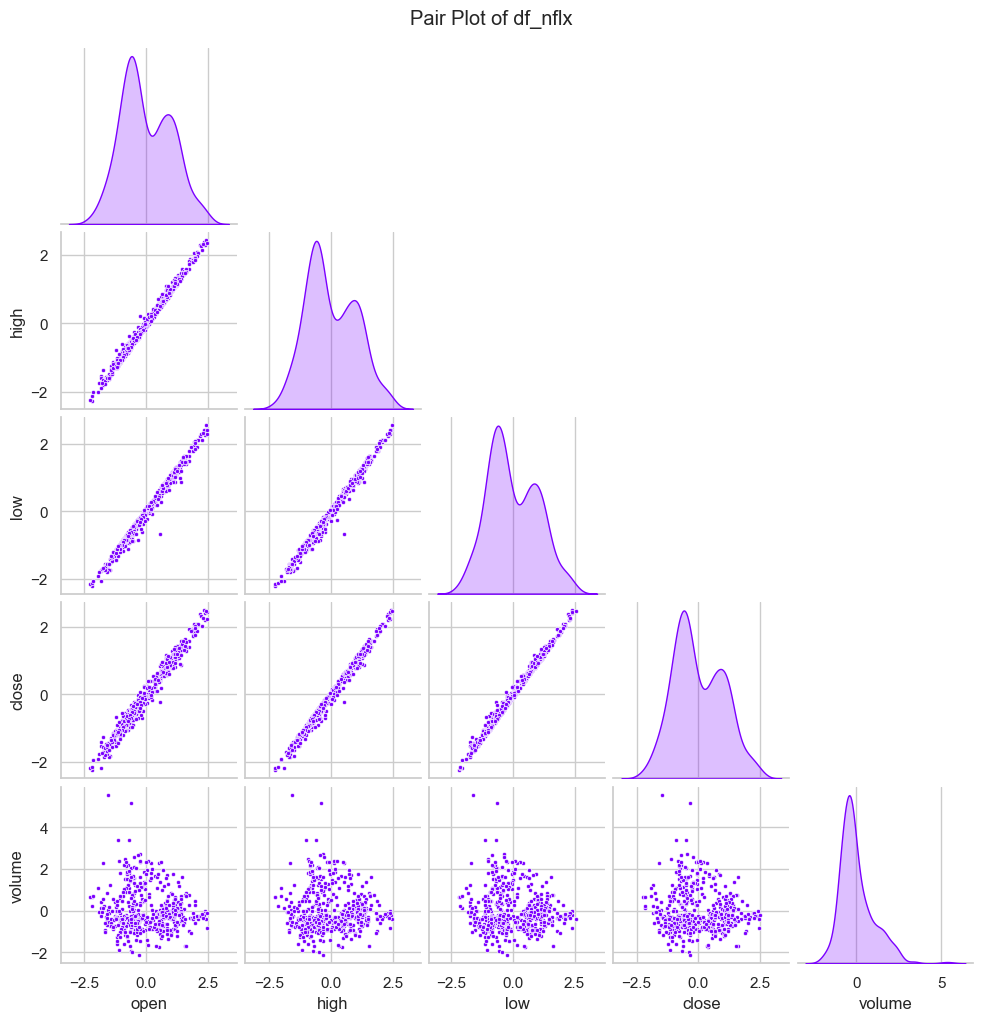

In [18]:
sns.set(style="whitegrid", palette="gist_rainbow_r")

pair_plot = sns.pairplot(df, corner=True, markers='.', diag_kind='kde', height=2)

pair_plot.fig.suptitle("Pair Plot of df_nflx", y=1.02)
plt.show()

# PREPARE DATA


In [19]:
df = df.reset_index()

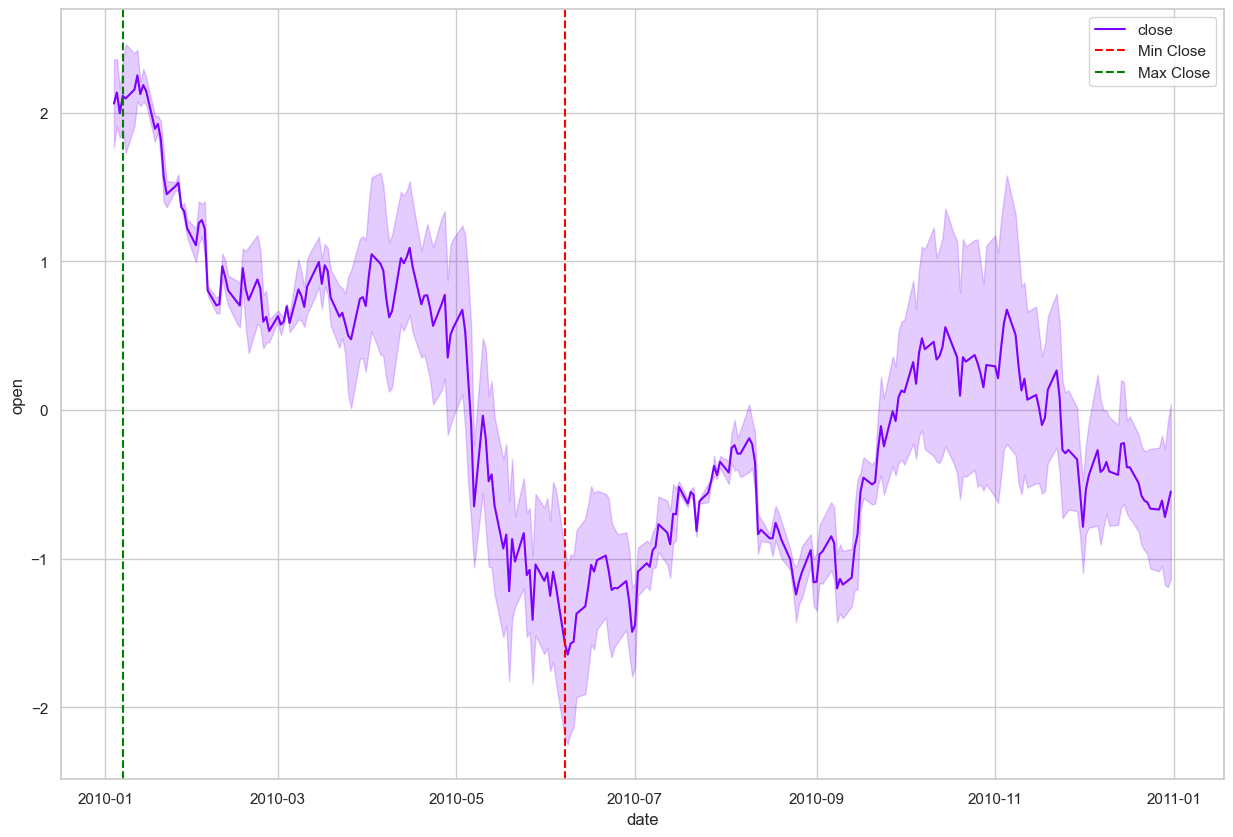

In [20]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df, x='date', y='open', label='close')
min_index = df['close'].idxmin()
max_index = df['close'].idxmax()
min_date = df.loc[min_index, 'date']
max_date = df.loc[max_index, 'date']
plt.axvline(x=min_date, color='r', linestyle='--', label='Min Close')
plt.axvline(x=max_date, color='g', linestyle='--', label='Max Close')
plt.legend()
plt.show()

In [21]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_plot["close"].values.reshape(-1, 1))

In [22]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length, 0]
        label = data[i + seq_length, 0]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [23]:
seq_length = 4
n_samples = len(data_scaled)
sequences, labels = create_sequences(data_scaled, seq_length)
split = int(0.8 * len(sequences))
X_train, y_train = sequences[:split], labels[:split]
X_test, y_test = sequences[split:], labels[split:]

# LSTM

In [24]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='tanh', input_shape=(seq_length, 1),return_sequences=True))
model_lstm.add(LSTM(50, activation='tanh'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [25]:
model_lstm.fit(X_train, y_train, epochs=30, batch_size=64,validation_data=(X_test, y_test))
predictions_lstm = model_lstm.predict(X_test)

Epoch 1/30
7/7 [==============================] - 7s 161ms/step - loss: 0.9107 - val_loss: 0.4941
Epoch 2/30
7/7 [==============================] - 0s 17ms/step - loss: 0.5359 - val_loss: 0.3333
Epoch 3/30
7/7 [==============================] - 0s 17ms/step - loss: 0.2431 - val_loss: 0.1282
Epoch 4/30
7/7 [==============================] - 0s 16ms/step - loss: 0.1602 - val_loss: 0.0357
Epoch 5/30
7/7 [==============================] - 0s 16ms/step - loss: 0.1035 - val_loss: 0.0507
Epoch 6/30
7/7 [==============================] - 0s 17ms/step - loss: 0.1166 - val_loss: 0.0411
Epoch 7/30
7/7 [==============================] - 0s 16ms/step - loss: 0.1027 - val_loss: 0.0346
Epoch 8/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0980 - val_loss: 0.0371
Epoch 9/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0997 - val_loss: 0.0375
Epoch 10/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0962 - val_loss: 0.0348
Epoch 11/30
7/7 [===========

In [26]:
predictions__LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
dates_test = df['date'].iloc[split + seq_length:]
df_plot_lstm = pd.DataFrame({'Dates': dates_test, 'Real': y_test_actual_LSTM.flatten(), 'Predict': predictions__LSTM.flatten()})
df_plot_lstm.head(3)

,Dates,Real,Predict
416,2010-08-10,-0.550397,-0.376318
417,2010-08-11,-0.961637,-0.404004
418,2010-08-12,-0.871025,-0.529219


# LSTM + ATTENTION

In [28]:
model_lstm_attention = Sequential()
model_lstm_attention.add(LSTM(100, activation='tanh', input_shape=(seq_length, 1), return_sequences=True, kernel_initializer=HeNormal()))
model_lstm_attention.add(SeqSelfAttention(attention_activation='tanh'))
model_lstm_attention.add(LSTM(50, activation='tanh', return_sequences=False, kernel_initializer=HeNormal()))
model_lstm_attention.add(Dense(1, kernel_initializer=HeNormal()))
model_lstm_attention.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

c:\Users\Arthur G\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [29]:
model_lstm_attention.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))
predictions_scaled_lstm_attention = model_lstm_attention.predict(X_test)

Epoch 1/40
13/13 [==============================] - 5s 96ms/step - loss: 0.4215 - val_loss: 0.0830
Epoch 2/40
13/13 [==============================] - 0s 21ms/step - loss: 0.1669 - val_loss: 0.0417
Epoch 3/40
13/13 [==============================] - 0s 16ms/step - loss: 0.1095 - val_loss: 0.0519
Epoch 4/40
13/13 [==============================] - 0s 17ms/step - loss: 0.0928 - val_loss: 0.0399
Epoch 5/40
13/13 [==============================] - 0s 16ms/step - loss: 0.0805 - val_loss: 0.0296
Epoch 6/40
13/13 [==============================] - 0s 16ms/step - loss: 0.0720 - val_loss: 0.0304
Epoch 7/40
13/13 [==============================] - 0s 16ms/step - loss: 0.0678 - val_loss: 0.0295
Epoch 8/40
13/13 [==============================] - 0s 16ms/step - loss: 0.0615 - val_loss: 0.0298
Epoch 9/40
13/13 [==============================] - 0s 16ms/step - loss: 0.0586 - val_loss: 0.0259
Epoch 10/40
13/13 [==============================] - 0s 16ms/step - loss: 0.0576 - val_loss: 0.0417
Epoch 11/

In [30]:
predictions_lstm_attention = scaler.inverse_transform(predictions_scaled_lstm_attention)
y_test_lstm_attention = scaler.inverse_transform(y_test.reshape(-1, 1))

In [31]:
df_plot_lstm_attention = pd.DataFrame({'Dates': dates_test, 'Real':y_test_lstm_attention.flatten(), 'Predict': predictions_lstm_attention.flatten()})
df_plot_lstm_attention.head(3)

,Dates,Real,Predict
416,2010-08-10,-0.550397,-0.328083
417,2010-08-11,-0.961637,-0.456995
418,2010-08-12,-0.871025,-0.780110


# RNN

In [32]:
# Setting a seed for the HeNormal initializer
he_normal_initializer = HeNormal(seed=42)

model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, activation='tanh', input_shape=(seq_length, 1), return_sequences=True, kernel_initializer=he_normal_initializer))
model_RNN.add(SeqSelfAttention(attention_activation='tanh', kernel_initializer=he_normal_initializer))
model_RNN.add(SimpleRNN(50, activation='tanh', kernel_initializer=he_normal_initializer))
model_RNN.add(Dense(1, kernel_initializer=he_normal_initializer))
model_RNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [33]:
model_RNN.fit(X_train, y_train, epochs=30, batch_size=64,validation_data=(X_test, y_test))
predictions_scaled_RNN = model_RNN.predict(X_test)

Epoch 1/30
7/7 [==============================] - 3s 100ms/step - loss: 0.4882 - val_loss: 0.0268
Epoch 2/30
7/7 [==============================] - 0s 26ms/step - loss: 0.1338 - val_loss: 0.0365
Epoch 3/30
7/7 [==============================] - 0s 28ms/step - loss: 0.0942 - val_loss: 0.0304
Epoch 4/30
7/7 [==============================] - 0s 27ms/step - loss: 0.0618 - val_loss: 0.0282
Epoch 5/30
7/7 [==============================] - 0s 27ms/step - loss: 0.0544 - val_loss: 0.0230
Epoch 6/30
7/7 [==============================] - 0s 28ms/step - loss: 0.0539 - val_loss: 0.0260
Epoch 7/30
7/7 [==============================] - 0s 27ms/step - loss: 0.0503 - val_loss: 0.0248
Epoch 8/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0481 - val_loss: 0.0248
Epoch 9/30
7/7 [==============================] - 0s 28ms/step - loss: 0.0462 - val_loss: 0.0221
Epoch 10/30
7/7 [==============================] - 0s 25ms/step - loss: 0.0456 - val_loss: 0.0235
Epoch 11/30
7/7 [===========

In [34]:
predictions_RNN = scaler.inverse_transform(predictions_scaled_RNN)
y_test_RNN = scaler.inverse_transform(y_test.reshape(-1, 1))

In [35]:
df_plot_RNN = pd.DataFrame({'Dates': dates_test, 'Real': y_test_RNN.flatten(),'Predict': predictions_RNN.flatten()})
df_plot_RNN.head(3)

,Dates,Real,Predict
416,2010-08-10,-0.550397,-0.355015
417,2010-08-11,-0.961637,-0.534764
418,2010-08-12,-0.871025,-0.890648


# GRU

In [36]:
model_gru = Sequential()
model_gru.add(GRU(100, activation='tanh', input_shape=(seq_length, 1),return_sequences=True))
model_gru.add(GRU(50, activation='tanh'))
model_gru.add(Dense(1))
model_gru.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [37]:
model_gru.fit(X_train, y_train, epochs=30, batch_size=32,validation_data=(X_test, y_test))
predictions_scaled_gru = model_gru.predict(X_test)

Epoch 1/30
13/13 [==============================] - 4s 71ms/step - loss: 0.2468 - val_loss: 0.1056
Epoch 2/30
13/13 [==============================] - 0s 12ms/step - loss: 0.0748 - val_loss: 0.0268
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 0.0555 - val_loss: 0.0202
Epoch 4/30
13/13 [==============================] - 0s 12ms/step - loss: 0.0493 - val_loss: 0.0199
Epoch 5/30
13/13 [==============================] - 0s 14ms/step - loss: 0.0437 - val_loss: 0.0183
Epoch 6/30
13/13 [==============================] - 0s 13ms/step - loss: 0.0439 - val_loss: 0.0179
Epoch 7/30
13/13 [==============================] - 0s 14ms/step - loss: 0.0425 - val_loss: 0.0221
Epoch 8/30
13/13 [==============================] - 0s 13ms/step - loss: 0.0481 - val_loss: 0.0191
Epoch 9/30
13/13 [==============================] - 0s 14ms/step - loss: 0.0464 - val_loss: 0.0181
Epoch 10/30
13/13 [==============================] - 0s 13ms/step - loss: 0.0421 - val_loss: 0.0236
Epoch 11/

In [38]:
predictions_GRU = scaler.inverse_transform(predictions_scaled_gru)
y_test_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))

In [39]:
df_plot_GRU = pd.DataFrame({'Dates': dates_test, 'Real': y_test_GRU.flatten(),'Predict': predictions_GRU.flatten()})
df_plot_GRU.head(3)

,Dates,Real,Predict
416,2010-08-10,-0.550397,-0.397194
417,2010-08-11,-0.961637,-0.567271
418,2010-08-12,-0.871025,-0.966266


# Prediction Evaluation

In [40]:
mse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])
mse_lstm_attention = mean_squared_error(df_plot_lstm_attention['Real'],df_plot_lstm_attention['Predict'])
mse_rnn = mean_squared_error(df_plot_RNN['Real'], df_plot_RNN['Predict'])
mse_GRU = mean_squared_error(df_plot_GRU['Real'], df_plot_GRU['Predict'])

r2_lstm = r2_score(df_plot_lstm['Real'], df_plot_lstm['Predict'])
r2_df_plot_lstm_attention= r2_score(df_plot_lstm_attention['Real'],df_plot_lstm_attention['Predict'])
r2_rnn = r2_score(df_plot_RNN['Real'], df_plot_RNN['Predict'])
r2_GRU = r2_score(df_plot_GRU['Real'], df_plot_GRU['Predict'])

rmse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'],squared=False)
rmse_rnn = mean_squared_error(df_plot_lstm_attention['Real'],df_plot_lstm_attention['Predict'], squared=False)
rmse_lstm = mean_squared_error(df_plot_RNN['Real'], df_plot_RNN['Predict'],squared=False)
rmse_GRU = mean_squared_error(df_plot_GRU['Real'], df_plot_GRU['Predict'],squared=False)

c:\Users\Arthur G\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Arthur G\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Arthur G\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Arthur G\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: 

# LSTM / ATTENTION / GRU / RNN

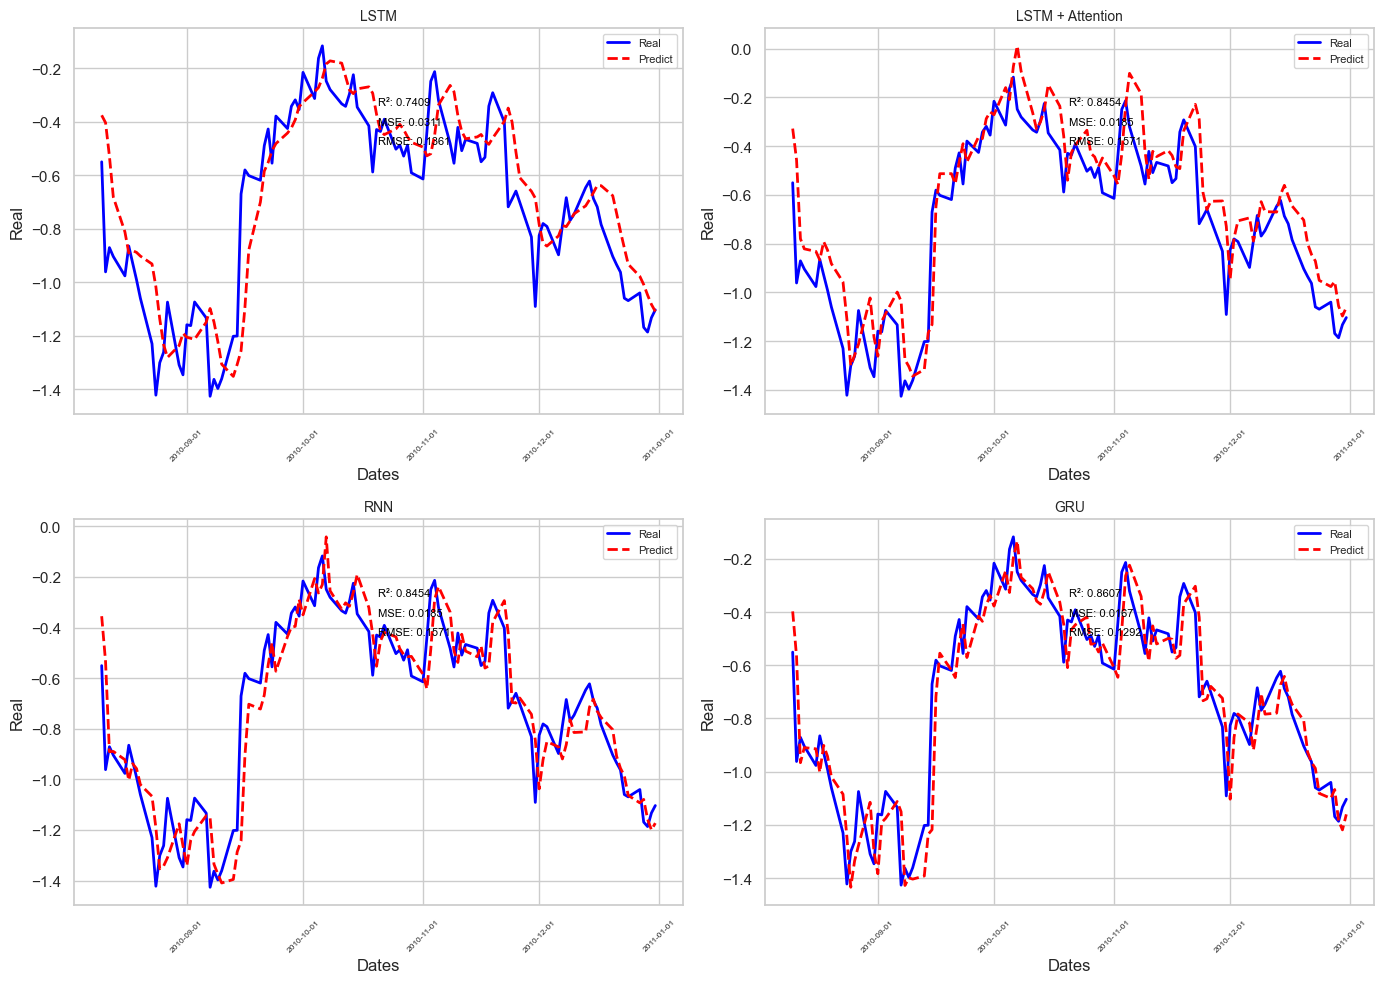

In [41]:
def plot_subplot(ax, df_real, df_predict, title, r2, mse, rmse):
    sns.lineplot(
        x="Dates",
        y="Real",
        data=df_real,
        label="Real",
        color="blue",
        ax=ax,
        linewidth=2,
    )
    sns.lineplot(
        x="Dates",
        y="Predict",
        data=df_predict,
        label="Predict",
        color="red",
        linestyle="dashed",
        ax=ax,
        linewidth=2,
    )
    ax.text(
        0.5, 0.80, f"R²: {r2:.4f}", fontsize=8, color="black", transform=ax.transAxes
    )
    ax.text(
        0.5, 0.75, f"MSE: {mse:.4f}", fontsize=8, color="black", transform=ax.transAxes
    )
    ax.text(
        0.5,
        0.70,
        f"RMSE: {rmse:.4f}",
        fontsize=8,
        color="black",
        transform=ax.transAxes,
    )
    ax.set_title(title, fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=6)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plot_subplot(
    axes[0, 0], df_plot_lstm, df_plot_lstm, "LSTM", r2_lstm, mse_lstm, rmse_lstm
)
plot_subplot(
    axes[0, 1],
    df_plot_lstm_attention,
    df_plot_lstm_attention,
    "LSTM + Attention",
    r2_rnn,
    mse_rnn,
    rmse_rnn,
)
plot_subplot(axes[1, 0], df_plot_RNN, df_plot_RNN, "RNN", r2_rnn, mse_rnn, rmse_rnn)
plot_subplot(axes[1, 1], df_plot_GRU, df_plot_GRU, "GRU", r2_GRU, mse_GRU, rmse_GRU)
plt.tight_layout()
plt.show()

# SAVE MODEL TO ONNX

In [42]:
# Save Model
model = [model_lstm, model_lstm_attention, model_RNN, model_gru]

inp_model_name = "model.Test.lstm-rnn-gru.onnx"
output_folder = "D:/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
output_path = os.path.join(output_folder, inp_model_name)
if os.path.exists(output_path):
    os.remove(output_path)

onnx_model = tf2onnx.convert.from_keras(model[1], output_path=output_path) # Select the model to analyze in mq5.
print(f"Model Saved in {output_path}")

Model Saved in D:/model.Test.lstm-rnn-gru.onnx
